<a href="https://www.kaggle.com/code/ziadhamadafathy/predict-house-prices?scriptVersionId=113756319" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 , f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import f1_score
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Preparing data and Cleaning it

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
print('Shape of train data: ', df_train.shape)
print('Shape of test data: ', df_test.shape)

Shape of train data:  (1460, 81)
Shape of test data:  (1459, 80)


In [5]:
null_columns=df_train.columns[df_train.isnull().any()]
df_train[null_columns].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [7]:
df_train.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], inplace=True)
df_test.drop(columns=['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu'], inplace=True)

In [8]:
X = df_train.drop(columns=['SalePrice'])
y = df_train['SalePrice']

In [9]:
df = pd.concat([X, df_test], axis=0)
df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


In [10]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtFinType2     80
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageType      157
GarageYrBlt     159
GarageFinish    159
GarageCars        1
GarageArea        1
GarageQual      159
GarageCond      159
SaleType          1
dtype: int64

In [11]:
df[null_columns].dtypes

MSZoning         object
LotFrontage     float64
Utilities        object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1      float64
BsmtFinType2     object
BsmtFinSF2      float64
BsmtUnfSF       float64
TotalBsmtSF     float64
Electrical       object
BsmtFullBath    float64
BsmtHalfBath    float64
KitchenQual      object
Functional       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageCars      float64
GarageArea      float64
GarageQual       object
GarageCond       object
SaleType         object
dtype: object

We Use KNNImputer in numerical columns to fill in missing values in a dataset using the k-Nearest Neighbors method 

In [12]:
cleaner = KNNImputer(n_neighbors=11, weights="distance")
numerical = df[null_columns].select_dtypes(exclude = "object").columns
df[numerical] = cleaner.fit_transform(df[numerical])

In [13]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

MSZoning          4
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinType2     80
Electrical        1
KitchenQual       1
Functional        2
GarageType      157
GarageFinish    159
GarageQual      159
GarageCond      159
SaleType          1
dtype: int64

By using ColumnTransformer, we fill the missing values by using mode

In [14]:
categorical = df[null_columns].select_dtypes(include = "object").columns
cleaner = ColumnTransformer([
    ('categorical_transformer', SimpleImputer(strategy='most_frequent'), categorical)
])
df[null_columns] = cleaner.fit_transform(df[null_columns])

To make sure that no null values in dataset

In [15]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Series([], dtype: float64)

In [16]:
categorical = df.select_dtypes(include = "object").columns
categorical

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [17]:
for i in range(0, len(categorical)):
    print(df[categorical[i]].value_counts())
    print('****************************************\n')

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
****************************************

Pave    2907
Grvl      12
Name: Street, dtype: int64
****************************************

Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
****************************************

Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
****************************************

AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64
****************************************

Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
****************************************

Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
****************************************

NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
M

**We do encoding for this columns by our hands because they are ordinal data**

In [18]:
LotShape =  {'Reg':0, 'IR1':1, 'IR2':2, 'IR3':3}
df['LotShape'] = df['LotShape'].replace(LotShape)

MSZoning = {'C':0, 'RH':1, 'RM':2, 'RL':3, 'RP':4}
df['MSZoning'] = df['MSZoning'].replace(MSZoning)

LandContour = {'Lvl':0, 'HLS':1, 'Bnk':2, 'Low':3}
df['LandContour'] = df['LandContour'].replace(LandContour)

LotConfig = {'Inside':0, 'Corner':1, 'CulDSac':2, 'FR2':3, 'FR3':4}
df['LotConfig'] = df['LotConfig'].replace(LotConfig)

LandSlope = {'Gtl':0, 'Mod':1, 'Sev':2}
df['LandSlope'] = df['LandSlope'].replace(LandSlope)

HouseStyle={'1Story':0, '1.5Fin':1, '1.5Unf':2, '2Story':3, '2.5Fin':4, '2.5Unf':5, 'SFoyer': 6, 'SLvl':7}
df['HouseStyle'] = df['HouseStyle'].replace(HouseStyle)

ExterQual = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
df['ExterQual'] = df['ExterQual'].replace(ExterQual)

BsmtQual = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['BsmtQual'] = df['BsmtQual'].replace(BsmtQual)

BsmtCond = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['BsmtCond'] = df['BsmtCond'].replace(BsmtCond)

BsmtExposure = {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Ex':4}
df['BsmtExposure'] = df['BsmtExposure'].replace(BsmtExposure)

BsmtFinType1 = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
df['BsmtFinType1'] = df['BsmtFinType1'].replace(BsmtFinType1)

BsmtFinType2 = {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}
df['BsmtFinType2'] = df['BsmtFinType2'].replace(BsmtFinType2)

Electrical = {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4}
df['Electrical'] = df['Electrical'].replace(Electrical)

KitchenQual = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
df['KitchenQual'] = df['KitchenQual'].replace(KitchenQual)

Functional = {'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7}
df['Functional'] = df['Functional'].replace(Functional)

GarageFinish =  {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}
df['GarageFinish'] = df['GarageFinish'].replace(GarageFinish)

GarageQual = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['GarageQual'] = df['GarageQual'].replace(GarageQual)

GarageCond = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
df['GarageCond'] = df['GarageCond'].replace(GarageCond)

PavedDrive = {'Dirt/Gravel':0, 'Partial Pavement':1, 'Paved':2}
df['PavedDrive'] = df['PavedDrive'].replace(PavedDrive)

In [19]:
cat_col = df.select_dtypes(include=['object']).columns
encoder = preprocessing.LabelEncoder()
for i in range(0, len(cat_col)):
    df[cat_col[i]] = encoder.fit_transform(df[cat_col[i]].astype(str))

**Splitting test and train data**

In [20]:
X = df.iloc[:1460, :]
df_test = df.iloc[1460:, :]

In [21]:
new_train = pd.concat([X, y], axis=1)

In [22]:
new_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,2,65.0,8450,1,0,0,0,0,0,...,0,0,0,0,0,2,2008,8,4,208500
1,20,2,80.0,9600,1,0,0,0,3,0,...,0,0,0,0,0,5,2007,8,4,181500
2,60,2,68.0,11250,1,1,0,0,0,0,...,0,0,0,0,0,9,2008,8,4,223500
3,70,2,60.0,9550,1,1,0,0,1,0,...,272,0,0,0,0,2,2006,8,0,140000
4,60,2,84.0,14260,1,1,0,0,3,0,...,0,0,0,0,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,2,62.0,7917,1,0,0,0,0,0,...,0,0,0,0,0,8,2007,8,4,175000
1456,20,2,85.0,13175,1,0,0,0,0,0,...,0,0,0,0,0,2,2010,8,4,210000
1457,70,2,66.0,9042,1,0,0,0,0,0,...,0,0,0,0,2500,5,2010,8,4,266500
1458,20,2,68.0,9717,1,0,0,0,0,0,...,112,0,0,0,0,4,2010,8,4,142125


**We do slice visualize for data to delete outliers**

<AxesSubplot:ylabel='SalePrice'>

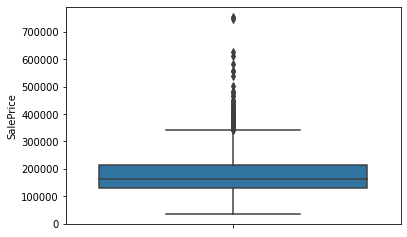

In [23]:
sns.boxplot(y=new_train['SalePrice'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

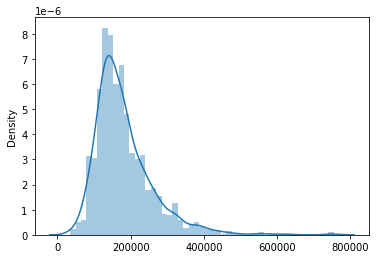

In [24]:
sns.distplot(x=new_train['SalePrice'])

In [25]:
new_train.drop(new_train[(new_train['SalePrice'] > 600000)].index, inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

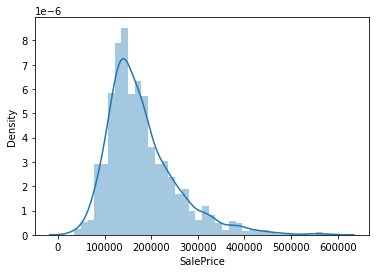

In [26]:
sns.distplot(new_train['SalePrice'])

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='GrLivArea'>

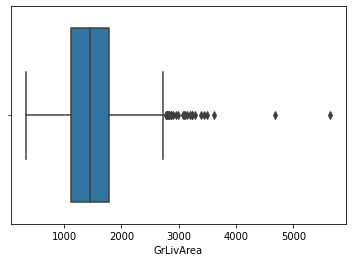

In [27]:
sns.boxplot(new_train['GrLivArea'])

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

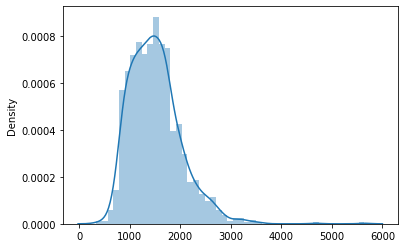

In [28]:
sns.distplot(x=new_train['GrLivArea'])

In [29]:
new_train.drop(new_train[(new_train['GrLivArea'] > 4000)].index, inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

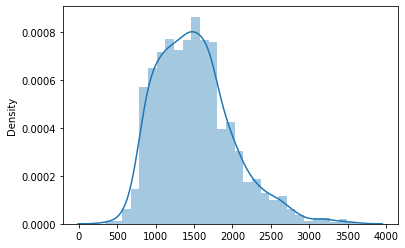

In [30]:
sns.distplot(x=new_train['GrLivArea'])

In [31]:
new_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,2,65.0,8450,1,0,0,0,0,0,...,0,0,0,0,0,2,2008,8,4,208500
1,20,2,80.0,9600,1,0,0,0,3,0,...,0,0,0,0,0,5,2007,8,4,181500
2,60,2,68.0,11250,1,1,0,0,0,0,...,0,0,0,0,0,9,2008,8,4,223500
3,70,2,60.0,9550,1,1,0,0,1,0,...,272,0,0,0,0,2,2006,8,0,140000
4,60,2,84.0,14260,1,1,0,0,3,0,...,0,0,0,0,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,2,62.0,7917,1,0,0,0,0,0,...,0,0,0,0,0,8,2007,8,4,175000
1456,20,2,85.0,13175,1,0,0,0,0,0,...,0,0,0,0,0,2,2010,8,4,210000
1457,70,2,66.0,9042,1,0,0,0,0,0,...,0,0,0,0,2500,5,2010,8,4,266500
1458,20,2,68.0,9717,1,0,0,0,0,0,...,112,0,0,0,0,4,2010,8,4,142125


We won't use all columns in dataset but we will use the most influential columns in SalePrice

In [32]:
X = new_train.drop(columns=['SalePrice'])
y = new_train['SalePrice'] 

FeatureSelection = SelectKBest(score_func= f_classif ,k=25)
X = FeatureSelection.fit_transform(X, y)
#showing X Dimension 
print('X Shape is ' , X.shape)

X Shape is  (1454, 25)


# Correlation among features

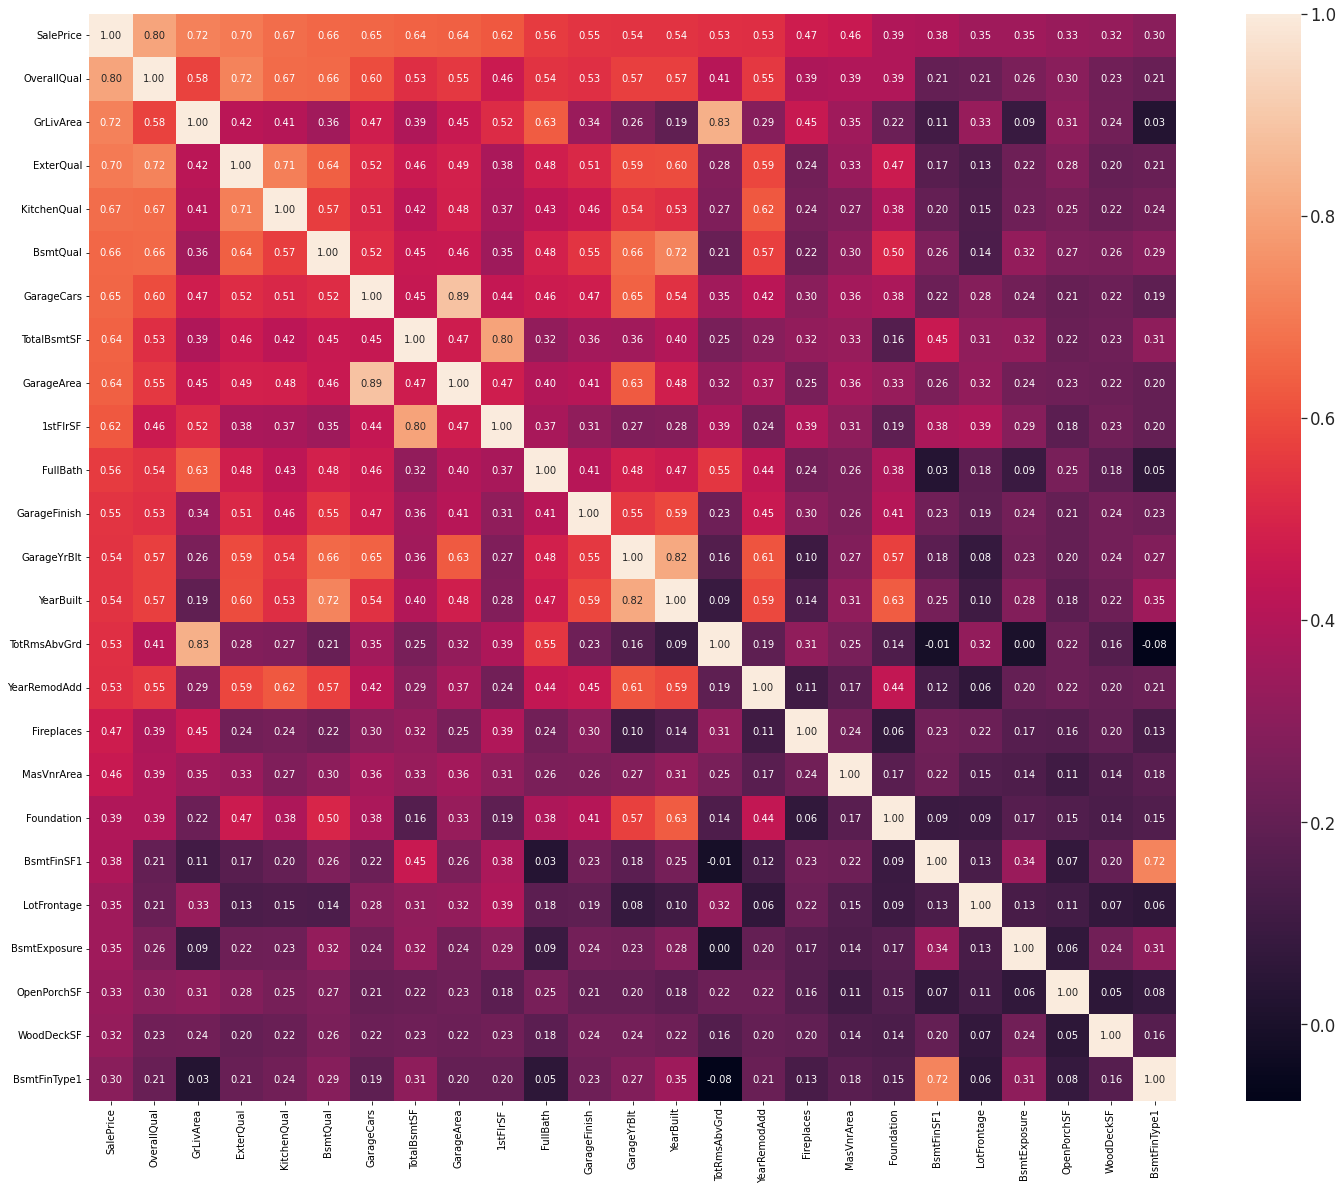

In [33]:
corrmat = new_train.corr()
f, ax = plt.subplots(figsize=(25, 20))
cols = corrmat.nlargest(25, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(new_train[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Spliting data

In [34]:
data = new_train[cols]
data

,SalePrice,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,TotalBsmtSF,GarageArea,1stFlrSF,...,YearRemodAdd,Fireplaces,MasVnrArea,Foundation,BsmtFinSF1,LotFrontage,BsmtExposure,OpenPorchSF,WoodDeckSF,BsmtFinType1
0,208500,7,1710,3,3,4,2.0,856.0,548.0,856,...,2003,0,196.0,2,706.0,65.0,0,61,0,6
1,181500,6,1262,2,2,4,2.0,1262.0,460.0,1262,...,1976,1,0.0,1,978.0,80.0,3,0,298,5
2,223500,7,1786,3,3,4,2.0,920.0,608.0,920,...,2002,1,162.0,2,486.0,68.0,1,42,0,6
3,140000,7,1717,2,3,3,3.0,756.0,642.0,961,...,1970,1,0.0,0,216.0,60.0,0,35,0,5
4,250000,8,2198,3,3,4,3.0,1145.0,836.0,1145,...,2000,1,350.0,2,655.0,84.0,2,84,192,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,175000,6,1647,2,2,4,2.0,953.0,460.0,953,...,2000,1,0.0,2,0.0,62.0,0,40,0,1
1456,210000,6,2073,2,2,4,2.0,1542.0,500.0,2073,...,1988,2,119.0,1,790.0,85.0,0,0,349,5
1457,266500,7,2340,4,3,3,1.0,1152.0,252.0,1188,...,2006,2,0.0,4,275.0,66.0,0,60,0,6
1458,142125,5,1078,2,3,3,1.0,1078.0,240.0,1078,...,1996,0,0.0,1,49.0,68.0,1,0,366,6


In [35]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle =True, random_state=150)

# GradientBoostingRegressor Model

In [36]:
GBRModel = GradientBoostingRegressor(n_estimators=300,max_depth=3,learning_rate = 0.09,random_state=1)
GBRModel.fit(X_train, y_train)
print('GBRModel Train Score is : ' , GBRModel.score(X_train, y_train))
print('GBRModel Test Score is : ' , GBRModel.score(X_test, y_test))

GBRModel Train Score is :  0.976775446278133
GBRModel Test Score is :  0.9201158293527799


In [37]:
y_pred_gbr = GBRModel.predict(X_test)
MSEValue_GB = mean_squared_error(y_test, y_pred_gbr, multioutput='uniform_average')
print('Mean Absolute Error Value is : ', np.sqrt(MSEValue_GB))

Mean Absolute Error Value is :  18183.312902343245


# RandomForestRegressor Model

In [38]:
RandomForestRegressorModel = RandomForestRegressor(max_depth=11,n_estimators=200,
                                                   criterion='absolute_error',random_state=1)
RandomForestRegressorModel.fit(X_train, y_train)
print('Random Forest Regressor Train Score is : ' , RandomForestRegressorModel.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , RandomForestRegressorModel.score(X_test, y_test))

Random Forest Regressor Train Score is :  0.9782373595902171
Random Forest Regressor Test Score is :  0.90161555261223


In [39]:
y_pred_rf = RandomForestRegressorModel.predict(X_test)
MSEValue_RF = mean_squared_error(y_test, y_pred_rf, multioutput='uniform_average')
print('Mean Absolute Error Value is : ', np.sqrt(MSEValue_RF))

Mean Absolute Error Value is :  20179.289556636424


In [40]:
XGBModel = XGBRegressor(n_estimators=200, max_depth=12, eta=0.09, subsample=0.6, colsample_bytree=0.8)
XGBModel.fit(X_train, y_train)

print('XGBoost Regressor Train Score is : ' , XGBModel.score(X_train, y_train))
print('XGBoost Regressor Test Score is : ' , XGBModel.score(X_test, y_test))

XGBoost Regressor Train Score is :  0.9999461500883589
XGBoost Regressor Test Score is :  0.9117910008875381


In [41]:
y_pred_x = XGBModel.predict(X_test)
MSEValue_X = mean_squared_error(y_test, y_pred_x, multioutput='uniform_average')
print('Mean Squared Error Value by Square root is : ', np.sqrt(MSEValue_X))

Mean Squared Error Value by Square root is :  19107.28994952873


## Submission

In [42]:
cols_test = cols.drop(['SalePrice'])

In [43]:
data_test = df_test[cols_test]
data_test

,OverallQual,GrLivArea,ExterQual,KitchenQual,BsmtQual,GarageCars,TotalBsmtSF,GarageArea,1stFlrSF,FullBath,...,YearRemodAdd,Fireplaces,MasVnrArea,Foundation,BsmtFinSF1,LotFrontage,BsmtExposure,OpenPorchSF,WoodDeckSF,BsmtFinType1
0,5,896,2,2,3,1.0,882.0,730.0,896,1,...,1961,0,0.0,1,468.0,80.0,0,0,140,3
1,6,1329,2,3,3,1.0,1329.0,312.0,1329,1,...,1958,0,108.0,1,923.0,81.0,0,36,393,5
2,5,1629,2,2,4,2.0,928.0,482.0,928,2,...,1998,1,0.0,2,791.0,74.0,0,34,212,6
3,6,1604,2,3,3,2.0,926.0,470.0,926,2,...,1998,1,20.0,2,602.0,78.0,0,36,360,6
4,8,1280,3,3,4,2.0,1280.0,506.0,1280,2,...,1992,0,0.0,2,263.0,43.0,0,82,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,4,1092,2,2,3,0.0,546.0,0.0,546,1,...,1970,0,0.0,1,0.0,21.0,0,0,0,1
1455,4,1092,2,2,3,1.0,546.0,286.0,546,1,...,1970,0,0.0,1,252.0,21.0,0,24,0,3
1456,5,1224,2,2,3,2.0,1224.0,576.0,1224,1,...,1996,1,0.0,1,1224.0,160.0,0,0,474,5
1457,5,970,2,2,4,0.0,912.0,0.0,970,1,...,1992,0,0.0,2,337.0,62.0,2,32,80,6


In [44]:
x_test = data_test.iloc[:]
y_pred_gbr = GBRModel.predict(x_test)
y_pred_rf = RandomForestRegressorModel.predict(x_test)
y_pred_x = XGBModel.predict(X_test)

In [45]:
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
submission = test[["Id"]]

submission["SalePrice"] = y_pred_gbr 
submission.to_csv('my_output_gbr.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
